## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

Symmetry, border gradient, and color histogram were measured to determine the malignancy of the lesion in the segmented picture.

import necessary libraries

In [1]:
%run functions.py

Using TensorFlow backend.
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seo/environments/my_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seo/environments/my_env/lib/p

In [2]:
test=pickle.load(open('testimage',"rb"))

In [15]:
imgname=list(test.keys())[0]

In [11]:
imgname

'ISIC_0030102.jpeg'

orig_img: original image<br>
dst: segmented image<br>
maxContourData: contour of the segmented image<br>
maxContour: Area of the contour<br>
mask: mask that is applied to the processed image to produce dst image

In [12]:
orig_img=test[imgname][0]
dst=test[imgname][1]
maxContourData=test[imgname][2]
maxContour=test[imgname][3]
mask=test[imgname][4]

(<matplotlib.image.AxesImage at 0x7f01dc220588>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 Text(0.5, 1.0, 'Region of interest'))

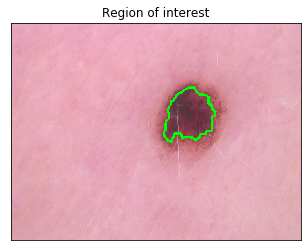

In [16]:
img=orig_img.copy()
img_with_contour=cv2.drawContours(img, maxContourData, -1, (0, 255, 0), 3) 
plt.imshow(img_with_contour),plt.xticks([]),plt.yticks([]), plt.title('Region of interest')

make empty dictionary that will contain all the information of the image

In [45]:
symmetry_dict=dict()
blue_dict=dict()
red_dict=dict()
green_dict=dict()
border_dict=dict()

Check for symmetry: bigger value more malignant

In [46]:
# get angle and center for rotation
(a,b),(MA,ma),angle = cv2.fitEllipse(maxContourData)
print(a,b,MA,ma,angle)
a=int(a)
b=int(b)

368.1972351074219 193.3366241455078 95.59439086914062 114.24609375 38.31223678588867


In [47]:
rotated_roi=rotate_bound(dst,angle,a,b)

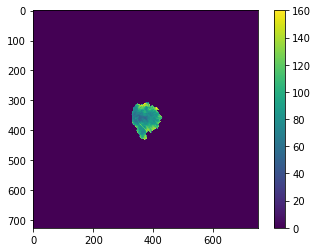

In [48]:
plt.imshow(rotated_roi)
plt.colorbar()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2bfe7952e8>,
 Text(0.5, 1.0, 'UD symmetry'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

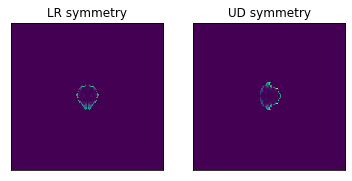

In [49]:
from mpl_toolkits.axes_grid1 import AxesGrid

imageO=rotated_roi
imageLR=np.fliplr(rotated_roi)
imageUD=np.flipud(rotated_roi)
plt.subplot(1,2,1),plt.imshow((imageO.astype("float")-imageLR.astype("float"))**2),plt.title('LR symmetry'),plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2),plt.imshow((imageO.astype("float")-imageUD.astype("float"))**2),plt.title('UD symmetry'),plt.xticks([]),plt.yticks([])

In [50]:
lr=mse(rotated_roi, np.fliplr(rotated_roi),maxContour)
ud=mse(rotated_roi, np.flipud(rotated_roi),maxContour)

In [51]:
print((lr+ud)/2)

3434.1258088601294


In [52]:
symmetry_dict[imgname]=(lr+ud)/2

Check Color: bigger value more malignant

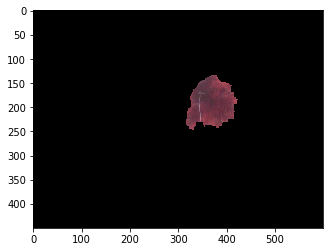

In [53]:
colorcheck = cv2.bitwise_and(orig_img, orig_img, mask=mask)
plt.imshow(colorcheck)

55.71407
92.03419
89.04805


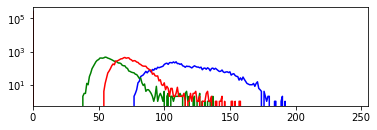

In [54]:
label=imgname.split('.')[0]
color = ('b','g','r')
fig=plt.figure()
zerovalues=list()
ax=fig.add_subplot(2,1,1)
b_list=[]
g_list=[]
r_list=[]
for i,col in enumerate(color):
    histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
    ax.plot(histr,color = col)
    zerovalues.append(histr[0])
    histr=histr[1:]
    plt.xlim([0,255])
    ax.set_yscale('log')
    if col=='b':
        blue_dict[label]=histr.std()
    if col=='g':
        green_dict[label]=histr.std()
    if col=='r':
        red_dict[label]=histr.std()
    print(histr.std())
plt.show()


Check border

In [55]:
H,W = img.shape[:2]
h=20; w=20
tots_gradient=[]
for point in maxContourData[:,0]:
    x=point[0]
    y=point[1]
    #print(x,y)
    y1=y-h; y2=y+h
    x1=x-w; x2=x+w
    if y1<0:
        y1=0
    if y2>H:
        y2=H
    if x1<0:
        x1=0
    if x2>W:
        x2=W
    #print(x1,y1,x2,y2)
    crop_img = orig_img[:,:,0][y1:y2, x1:x2].copy()
    mag,ang,gx,gy=get_mag_ang(crop_img)
    tots_gradient.append(mag.mean())

border_dict[imgname]=np.mean(tots_gradient)
print(np.mean(tots_gradient))

1.5675288


In [57]:
print(symmetry_dict,blue_dict,red_dict,green_dict,border_dict)

{'ISIC_0030102.jpeg': 3434.1258088601294} {'ISIC_0030102': 55.71407} {'ISIC_0030102': 89.04805} {'ISIC_0030102': 92.03419} {'ISIC_0030102.jpeg': 1.5675288}
